In [1]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# unzip file
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Dataset2C-20240422T052137Z-001.zip', 'r') # 'r' for read
zip_ref.extractall('/content') # extract to content file
zip_ref.close()

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import cv2
import PIL

In [4]:
data = '/content/Dataset2C'

In [5]:
def color_histogram(nameOfFruits, dataPath):
    fig, axs = plt.subplots(len(nameOfFruits), 1, figsize=(10, 5 * len(nameOfFruits)))

    for i, fruitName in enumerate(nameOfFruits):
        fruit_folder = os.path.join(dataPath, fruitName)
        image_files = os.listdir(fruit_folder)
        image_path = os.path.join(fruit_folder, image_files[0])
        image = PIL.Image.open(image_path)
        image_array = np.array(image)

        color_labels = ['Red', 'Green', 'Blue']
        colors = ['r', 'g', 'b']

        for j, (color, label) in enumerate(zip(colors, color_labels)):
            color_values = image_array[:,:,j].flatten()
            axs[i].hist(color_values, bins=256, color=color, alpha=0.5, label=label)

        axs[i].set_xlabel('intensity')
        axs[i].set_ylabel('frequency')
        axs[i].set_title(f'{fruitName} color histogram')

    plt.tight_layout()
    plt.show()

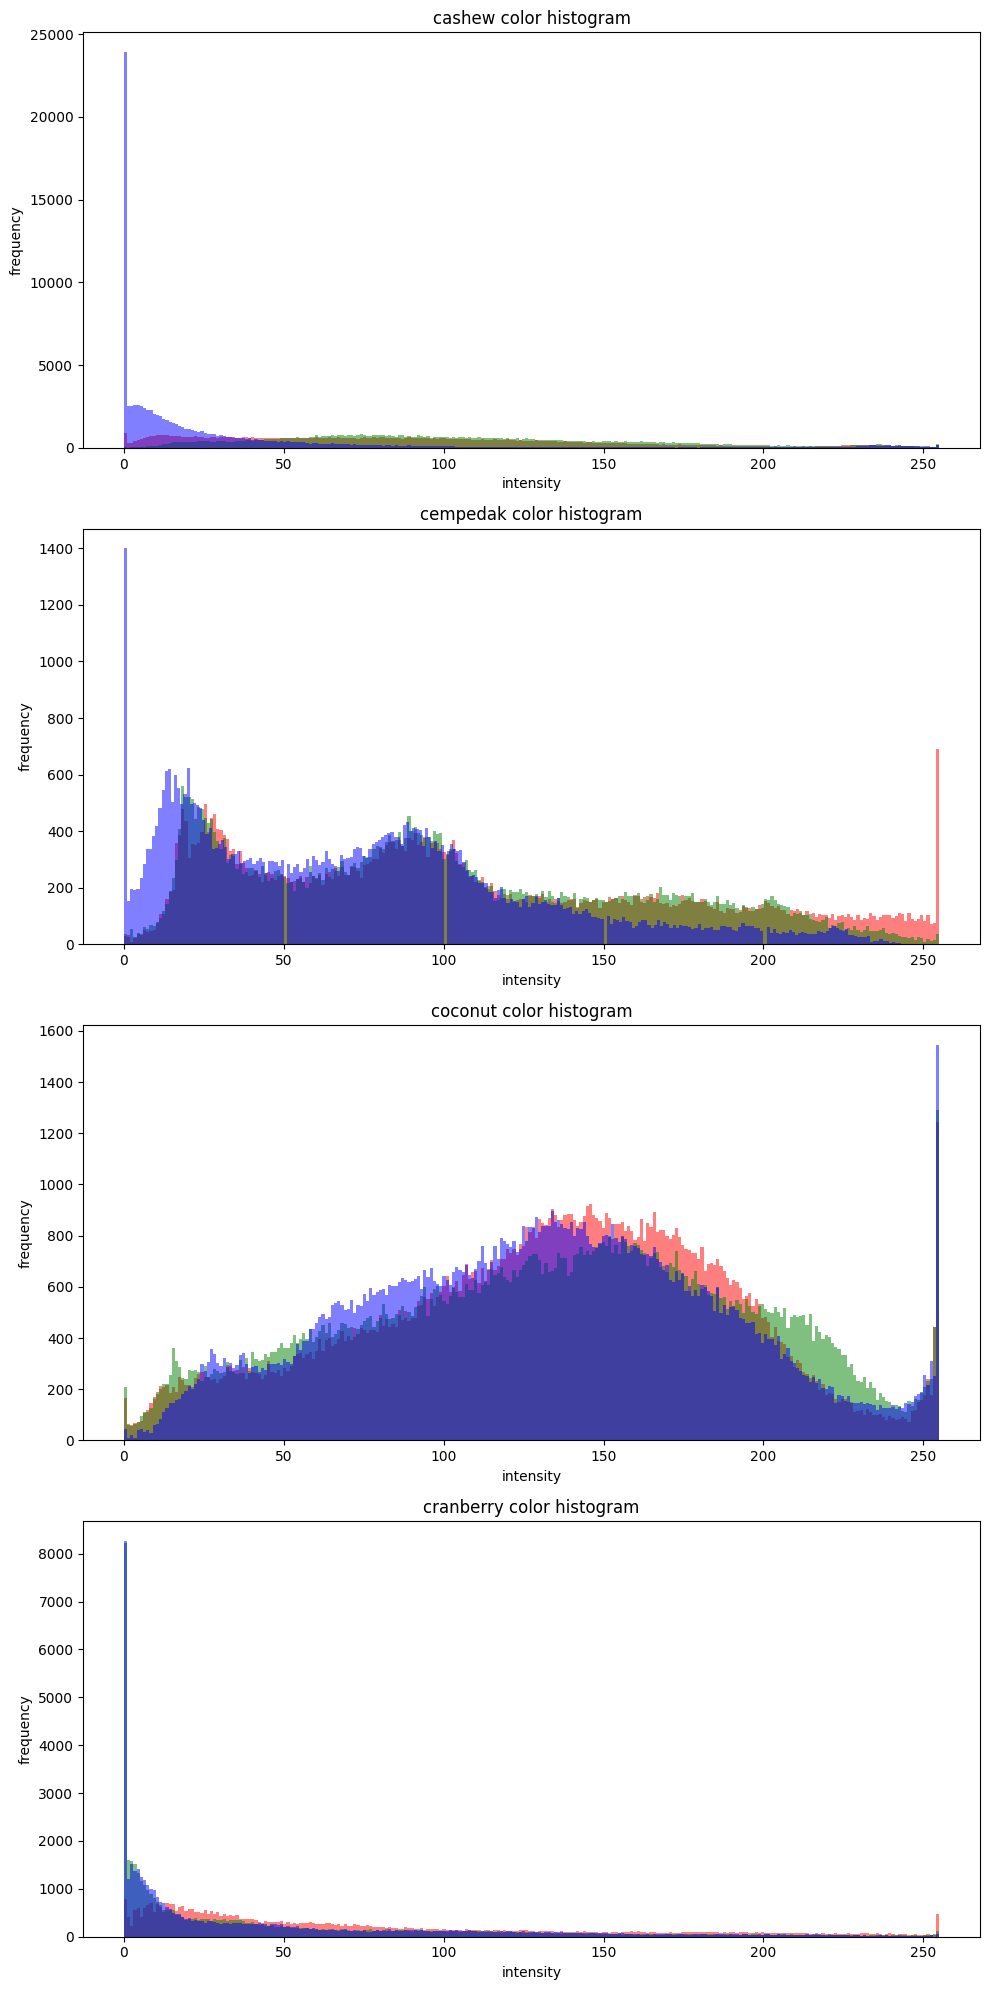

In [6]:
fruits = ['cashew', 'cempedak', 'coconut', 'cranberry']
color_histogram(fruits, data)

Color Histogram:


1.   Cashew: distribusi intensity dari Cashew tidak begitu baik dimana ada 1 peak yang tinggi di warna blue dan selanjutnya datar dan rendah, ini menandakan warna yang tidak seimbang dikarenakan adanya peak tersebut (blue lebih dominan). Persebaran intensity juga tidak begitu lebar dan lebih cenderung ke kiri sehingga bisa disimpulkan adanya contrast yang rendah dan juga brightness yang kurang.
2.   Cempedak: distribusi intensity dari Cempedak juga memiliki peak yang tinggi di warna blue dan juga peak yang lebih tinggi di warna red dan warna green yang kurang terlihat ada peak, tinggi dari frequency intensity juga tidak seimbang di kiri dan kanan sehingga warna tidak seimbang. Persebaran intensity lebar tetapi lebih cenderung ke kiri sehingga bisa disimpulkan contrast tinggi tapi brightness yang kurang.
3.   Coconut: distribusi intensity dari Coconut juga memiliki peak yang sangat tinggi untuk warna blue sehingga warna blue lebih dominan. Persebaran intensity sangat lebar dan lebih cenderung ke kanan sedikit. Bisa disimpulkan contrast tinggi dan brightness yang cukup baik.
4.   Cranberry: distribusi intensity tidak baik, ada peak yang tinggi untuk warna blue. Persebaran tidak begitu lebar dan cenderung ke kiri. Bisa disimpulkan warna tidak seimbang, contrast rendah dan brightness yang kurang baik.



In [7]:
data = pathlib.Path(data)
data

PosixPath('/content/Dataset2C')

In [8]:
image_length = len(list(data.glob('*/*.jpg')))
image_length

1610

In [9]:
fruit_image = {
    'cashew': list(data.glob('cashew/*')),
    'cempedak': list(data.glob('cempedak/*')),
    'coconut': list(data.glob('coconut/*')),
    'cranberry': list(data.glob('cranberry/*'))
}

In [10]:
fruit_image_index = {
    'cashew': 0,
    'cempedak': 1,
    'coconut': 2,
    'cranberry': 3
}

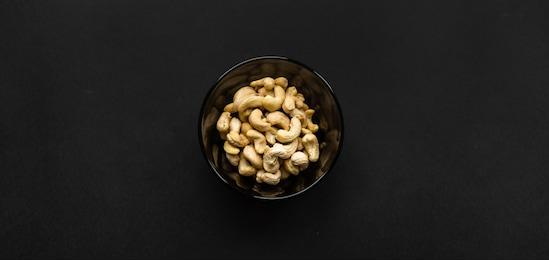

In [11]:
PIL.Image.open(str(list(data.glob('cashew/*'))[14]))

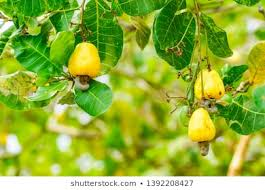

In [12]:
PIL.Image.open(str(list(data.glob('cashew/*'))[3]))

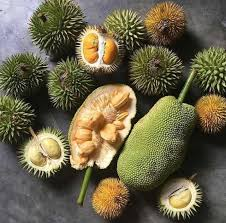

In [13]:
PIL.Image.open(str(list(data.glob('cempedak/*'))[0]))

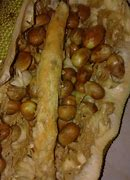

In [14]:
PIL.Image.open(str(list(data.glob('cempedak/*'))[60]))

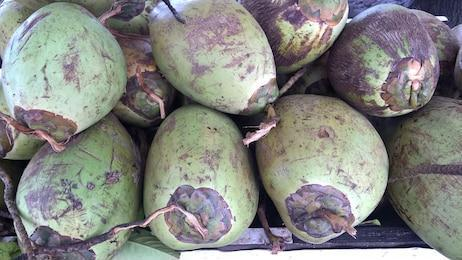

In [15]:
PIL.Image.open(str(list(data.glob('coconut/*'))[0]))

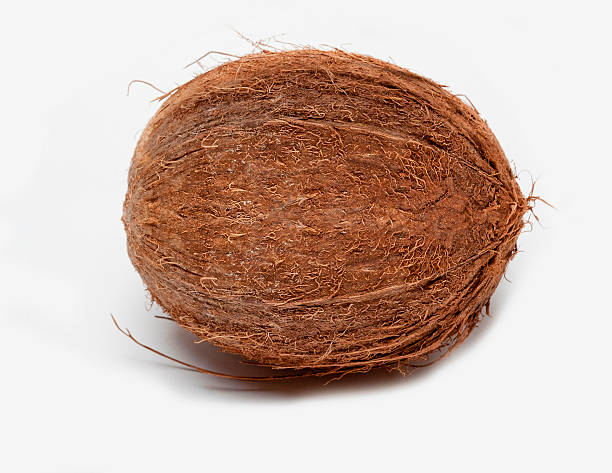

In [16]:
PIL.Image.open(str(list(data.glob('coconut/*'))[142]))

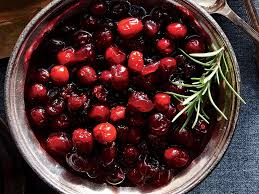

In [17]:
PIL.Image.open(str(list(data.glob('cranberry/*'))[0]))

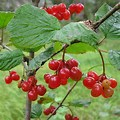

In [18]:
PIL.Image.open(str(list(data.glob('cranberry/*'))[130]))

In [19]:
X, y = [], []

for fruit_name, images in fruit_image.items():
  for image in images:
    img = cv2.imread(str(image))
    resized_img = cv2.resize(img, (224, 224))
    X.append(resized_img)
    y.append(fruit_image_index[fruit_name])

In [20]:
X[0].shape

(224, 224, 3)

In [21]:
X = np.array(X)
y = np.array(y)

In [22]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5, random_state = 0)

print("Training set size:", len(x_train))
print("Validation set size:", len(x_val))
print("Testing set size:", len(x_test))

Training set size: 1288
Validation set size: 161
Testing set size: 161


In [23]:
data_aug = Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape = (224, 224, 3)),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomContrast(0.2)
])

Data Augmentation diimplementasikan dengan adanya Random Flip secara horizontal untuk melihat dari perspective yang berbeda, ada juga input shape yang akan digunakan nanti di dalam model. Berikutnya ada Random Zoom dimana image akan di zoom in atau zoom out agar bisa dilihat lebih dekat atau jauh, karena ada image yang zoom ke buahnya. Selanjutnya ada Random Rotation dimana image akan di rotasikan untuk melihat dari arah yang berbeda. Terakhir ada Random Contrast untuk meningkatkan atau menurunkan contrast dari image karena dari histogram di atas dapat diketahui banyak yang tingkat contrastnya kurang baik.

In [24]:
model = Sequential([
    data_aug,
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation = 'relu'),
    layers.Conv2D(128, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation = 'relu'),
    layers.Conv2D(256, (3, 3), activation = 'relu'),
    layers.Conv2D(256, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, (3, 3), activation = 'relu'),
    layers.Conv2D(512, (3, 3), activation = 'relu'),
    layers.Conv2D(512, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, (3, 3), activation = 'relu'),
    layers.Conv2D(512, (3, 3), activation = 'relu'),
    layers.Conv2D(512, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(4096, activation = 'relu'),
    layers.Dense(4096, activation = 'relu'),
    layers.Dense(4, activation='softmax')
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 128)     147584    
                                                      

In [25]:
model.fit(x_train, y_train, epochs = 20, batch_size = 32, validation_data = (x_val, y_val))

Epoch 1/20
41/41 [==============================] - 50s 568ms/step - loss: 56.8103 - accuracy: 0.2438 - val_loss: 1.3872 - val_accuracy: 0.2422
Epoch 2/20
41/41 [==============================] - 14s 346ms/step - loss: 1.3892 - accuracy: 0.2531 - val_loss: 1.3868 - val_accuracy: 0.2236
Epoch 3/20
41/41 [==============================] - 14s 342ms/step - loss: 1.3922 - accuracy: 0.2453 - val_loss: 1.3869 - val_accuracy: 0.2422
Epoch 4/20
41/41 [==============================] - 14s 340ms/step - loss: 1.4060 - accuracy: 0.2399 - val_loss: 1.3867 - val_accuracy: 0.2236
Epoch 5/20
41/41 [==============================] - 14s 339ms/step - loss: 1.3902 - accuracy: 0.2415 - val_loss: 1.3869 - val_accuracy: 0.2236
Epoch 6/20
41/41 [==============================] - 14s 335ms/step - loss: 1.3873 - accuracy: 0.2531 - val_loss: 1.3874 - val_accuracy: 0.2236
Epoch 7/20
41/41 [==============================] - 14s 342ms/step - loss: 1.3863 - accuracy: 0.2438 - val_loss: 1.3820 - val_accuracy: 0.323

In [26]:
model.evaluate(x_test, y_test)

6/6 [==============================] - 1s 78ms/step - loss: 1.3860 - accuracy: 0.2547


[1.3859753608703613, 0.25465837121009827]

In [27]:
model_modify = Sequential([
    data_aug,
    layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation = 'relu', padding = 'same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation = 'relu', padding = 'same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation = 'relu', padding = 'same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, (3, 3), activation = 'relu', padding = 'same'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3, 3), activation = 'relu', padding = 'same'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3, 3), activation = 'relu', padding = 'same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, (3, 3), activation = 'relu', padding = 'same'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3, 3), activation = 'relu', padding = 'same'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3, 3), activation = 'relu', padding = 'same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(4096, activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(4096, activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(4, activation='softmax')
])

model_modify.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model_modify.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 224, 224, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_14 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_1 (Bat  (None, 224, 224, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 112, 112, 64)     

Dalam model_modify, ditambahkan BatchNormalization dan Dropout, BatchNormalization ditambahkan agar setiap output dari layer sebelumnya di normalisasi sehingga bisa membantu training proses untuk networknya belajar lebih mudah dan mencegah overfitting. Dropout ditambahkan agar network bisa belajar dari sub-network lain setiap kali ada batch baru data dan membantu mencegah overfitting. Jadi BatchNormalization membantu untuk training proses menjadi lebih stabil dan cepat dan Dropout membantu network agar tidak berkegantungan dengan neuron tertentu saja. Selain itu ditambahkan juga padding same agar pixel terluar dari image bisa terlihat.

In [28]:
model_modify.fit(x_train, y_train, epochs = 20, batch_size = 32, validation_data = (x_val, y_val))

Epoch 1/20
41/41 [==============================] - 67s 948ms/step - loss: 22.7337 - accuracy: 0.3183 - val_loss: 37631.0469 - val_accuracy: 0.2360
Epoch 2/20
41/41 [==============================] - 30s 739ms/step - loss: 2.6217 - accuracy: 0.4379 - val_loss: 588.2902 - val_accuracy: 0.2360
Epoch 3/20
41/41 [==============================] - 31s 748ms/step - loss: 1.6459 - accuracy: 0.4814 - val_loss: 26.8327 - val_accuracy: 0.3292
Epoch 4/20
41/41 [==============================] - 31s 746ms/step - loss: 1.4224 - accuracy: 0.5334 - val_loss: 4.1119 - val_accuracy: 0.3354
Epoch 5/20
41/41 [==============================] - 30s 743ms/step - loss: 1.0728 - accuracy: 0.5862 - val_loss: 2.2055 - val_accuracy: 0.4224
Epoch 6/20
41/41 [==============================] - 31s 747ms/step - loss: 1.0357 - accuracy: 0.5738 - val_loss: 1.5090 - val_accuracy: 0.4720
Epoch 7/20
41/41 [==============================] - 30s 732ms/step - loss: 1.0107 - accuracy: 0.5970 - val_loss: 1.4220 - val_accuracy

In [29]:
model_modify.evaluate(x_test, y_test)

6/6 [==============================] - 1s 110ms/step - loss: 0.7288 - accuracy: 0.6460


[0.7288391590118408, 0.6459627151489258]

Link video penjelasan: https://binusianorg-my.sharepoint.com/personal/brandon_yang_binus_ac_id/_layouts/15/guestaccess.aspx?share=Ee3mKl21rZ5HvDSOSwaSwZcBx3xwNT9u2cTjJXlevHKPFA&nav=eyJyZWZlcnJhbEluZm8iOnsicmVmZXJyYWxBcHAiOiJPbmVEcml2ZUZvckJ1c2luZXNzIiwicmVmZXJyYWxBcHBQbGF0Zm9ybSI6IldlYiIsInJlZmVycmFsTW9kZSI6InZpZXciLCJyZWZlcnJhbFZpZXciOiJNeUZpbGVzTGlua0NvcHkifX0&e=RheBLz